In [1]:
pip install myfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.9/426.9 kB 2.7 MB/s eta 0:00:00


In [2]:
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse as sps

import myfm
from myfm import RelationBlock
import pandas as pd

# read movielens  data.
from myfm.utils.benchmark_data import MovieLens100kDataManager
#from myfm.utils.benchmark_data import MovieLens1MDataManager

In [3]:
#from myfm.utils.benchmark_data import MovieLens10MDataManager

In [3]:
#data_manager = MovieLens10MDataManager()
data_manager = MovieLens100kDataManager()

Could not find /root/.ml-100k.zip.
Can I download and save it there?[y/N]y
start download...
complete


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163752 sha256=423eb70092b7786a253ec24d2342e0f0aaf7d8293d1341cc7c0a323f0cd409fd
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [6]:
from surprise import Dataset, Reader

In [7]:
data_manager


In [8]:
df_train, df_test = data_manager.load_rating_kfold_split(K=10, fold=0)

# For ordered probit. rating values are now [0, 1, 2, 3, 4].
df_train.rating -= 1
df_test.rating -= 1

# Create dictionaries which map user/movie ids to internal indices.
# We have also prepared a utility class which makes this common routine easier.
# See the script version of this notebook (ml-1m-regression.py).
unique_user_ids = np.unique(df_train.user_id)
unique_movie_ids = np.unique(df_test.movie_id)
user_id_to_index = { uid: i for i, uid in enumerate(unique_user_ids)}
movie_id_to_index = { mid: i for i, mid in enumerate(unique_movie_ids)}

In [9]:
# treat the days of events as categorical variable
date_be = OneHotEncoder(handle_unknown='ignore').fit(
    df_train.timestamp.dt.floor('d').values.reshape(-1, 1)
)
def categorize_date(dates: pd):
    return date_be.transform(
        pd.to_datetime(dates).dt.floor('d').values.reshape((-1, 1))
    )

In [10]:
# Implement side information and flavor of SVD++
# We add "all users who have evaluated a movie in the train set" or
# "all movies rated by a user" as a feature of user/movie.
use_date = True # use date info or not
use_iu = True # use implicit user feature
use_ii = True # use implicit item feature

movie_vs_watched = dict()
user_vs_watched = dict()
for row in df_train.itertuples():
    user_id = row.user_id
    movie_id = row.movie_id
    movie_vs_watched.setdefault(movie_id, list()).append(user_id)
    user_vs_watched.setdefault(user_id, list()).append(movie_id)

if use_date:
    X_date_train = categorize_date(df_train.timestamp)
    X_date_test  = categorize_date(df_test.timestamp)
else:
    X_date_train, X_date_test = (None, None)

In [11]:
# setup grouping
feature_group_sizes = []
if use_date:
    feature_group_sizes.append(
        len(date_be.categories_[0]), # date
    )

feature_group_sizes.append(len(user_id_to_index)) # user ids

if use_iu:
    feature_group_sizes.append(len(movie_id_to_index))

feature_group_sizes.append(len(movie_id_to_index)) # movie ids

if use_ii:
    feature_group_sizes.append(
        len(user_id_to_index) # all users who watched the movies
    )

In [12]:
feature_group_sizes

[213, 943, 1257, 1257, 943]

In [13]:
# given user/movie ids, add additional infos and return it as sparse
def augment_user_id(user_ids):
    X = sps.lil_matrix((len(user_ids), len(user_id_to_index) + (len(movie_id_to_index) if use_iu else 0) ))
    for index, user_id in enumerate(user_ids):
        if user_id in user_id_to_index:
            X[index, user_id_to_index[user_id]] = 1
        if not use_iu:
            continue
        watched_movies = user_vs_watched.get(user_id, [])
        normalizer = 1 / max(len(watched_movies), 1) ** 0.5
        for mid in watched_movies:
            if mid in movie_id_to_index:
                X[index, movie_id_to_index[mid] + len(user_id_to_index)] = normalizer
    return X.tocsr()

def augment_movie_id(movie_ids):
    X = sps.lil_matrix((len(movie_ids), len(movie_id_to_index)+ (len(user_id_to_index) if use_ii else 0 )))
    for index, movie_id in enumerate(movie_ids):
        if movie_id in movie_id_to_index:
            X[index, movie_id_to_index[movie_id]] = 1
        if not use_ii:
            continue
        watched_users = movie_vs_watched.get(movie_id, [])
        normalizer = 1 / max(len(watched_users), 1) ** 0.5
        for uid in watched_users:
            if uid in user_id_to_index:
                X[index, user_id_to_index[uid] + len(movie_id_to_index)] = normalizer
    return X.tocsr()

In [14]:
# Create RelationBlock.
train_blocks = []
test_blocks = []
for source, target in [(df_train, train_blocks), (df_test, test_blocks)]:
    unique_users, user_map = np.unique(source.user_id, return_inverse=True)
    target.append(
        RelationBlock(user_map, augment_user_id(unique_users))
    )
    unique_movies, movie_map = np.unique(source.movie_id, return_inverse=True)
    target.append(
        RelationBlock(movie_map, augment_movie_id(unique_movies))
    )

VariationalFMRegressor

VariationalFMClassifier


MyFMGibbsClassifier

In [15]:
fm1 = myfm.VariationalFMRegressor(rank=32)
fm1.fit(
    X_date_train, df_train.rating.values, X_rel=train_blocks,
    group_shapes=feature_group_sizes,
    n_iter=200
);

alpha = 1.22 w0 = 1.96 : 100%|██████████| 200/200 [01:57<00:00,  1.71it/s]


In [17]:
test_prediction_regressor = fm1.predict(X_date_test, test_blocks)

In [18]:
# RMSE for regressor
# you can clip the value with
test_prediction_regressor[test_prediction_regressor >=4] = 4
test_prediction_regressor[test_prediction_regressor <=0] = 0
(
    (df_test.rating.values - test_prediction_regressor)**2
).mean() ** 0.5

0.8880580446661344

In [19]:
fm2 = myfm.MyFMGibbsRegressor(rank=32)
fm2.fit(
    X_date_train, df_train.rating.values, X_rel=train_blocks,
    group_shapes=feature_group_sizes,
    n_iter=200
);

alpha = 2.20 w0 = 2.50 : 100%|██████████| 200/200 [01:03<00:00,  3.17it/s]


In [20]:
test_prediction_regressor = fm2.predict(X_date_test, test_blocks)

In [21]:
(
    (df_test.rating.values - test_prediction_regressor)**2
).mean() ** 0.5

0.8770110681108894

In [22]:
fm = myfm.MyFMRegressor(rank=32)
fm.fit(
    X_date_train, df_train.rating.values, X_rel=train_blocks,
    group_shapes=feature_group_sizes,
    n_iter=200
);

alpha = 2.20 w0 = 2.50 : 100%|██████████| 200/200 [01:00<00:00,  3.28it/s]


In [23]:
from myfm import MyFMOrderedProbit

In [24]:
fm_order = myfm.MyFMOrderedProbit(rank=32)
#assert false
fm_order.fit(X_date_train, df_train.rating.values, X_rel=train_blocks,group_shapes=feature_group_sizes,n_iter=200);


w0 = 0.22, cutpoint = ['-2.701', '-1.507', '-0.022', '1.698'] : 100%|██████████| 200/200 [01:13<00:00,  2.73it/s]


In [25]:
from matplotlib import pyplot as plt

In [26]:
assert fm_order.history_ is not None

In [27]:
cutpoints = fm_order.cutpoint_samples - fm_order.w0_samples[:, None]

In [28]:
test_prediction_regressor = fm.predict(X_date_test, test_blocks)

In [29]:
test_prediction_oprobit = fm_order.predict_proba(X_date_test, test_blocks)

In [30]:
test_prediction_oprobit_mean = test_prediction_oprobit.dot(np.arange(5))

In [31]:
# RMSE for regressor
# you can clip the value with
test_prediction_regressor[test_prediction_regressor >=4] = 4
test_prediction_regressor[test_prediction_regressor <=0] = 0
(
    (df_test.rating.values - test_prediction_regressor)**2
).mean() ** 0.5

0.8761102791699252

In [32]:
# RMSE for ordered probit regressor
((df_test.rating.values - test_prediction_oprobit_mean)**2
).mean() ** 0.5

0.8732009604109965

In [33]:
from sklearn.metrics import mean_absolute_error as mae

In [34]:
error = mae(df_test.rating.values, test_prediction_regressor)
print("Mean absolute error : " + str(error))

Mean absolute error : 0.6828003513144596


In [35]:
error1 = mae(df_test.rating.values,test_prediction_oprobit_mean)
print("Mean absolute error : " + str(error1))

Mean absolute error : 0.682544958124383


In [106]:
df['OPRFM_score'] =  test_prediction_oprobit_mean

In [105]:
columns = ['OPRFM_score', 'score']
df = pd.DataFrame(columns=columns)

In [107]:
print(len(df['OPRFM_score']))

10000


In [108]:
df = df.sort_values(by='OPRFM_score', ascending=False)

In [109]:
df.head(1)

,OPRFM_score,score
7052,3.999029,NaN


In [110]:
# Extract true relevance scores and convert them to a 2D array
true_relevance = df['OPRFM_score'].values.reshape(1, -1)

In [111]:
from sklearn.metrics import ndcg_score
ndcg_5 = ndcg_score(true_relevance, np.ones_like(true_relevance) * 10)

In [112]:
print(f"NDCG@5: {ndcg_5}")

NDCG@5: 0.9633293941872825


In [115]:
df.head(1)

,OPRFM_score,score
7052,3.999029,2.957237


In [101]:
from sklearn.metrics import precision_score

In [114]:
df['score'] =  test_prediction_oprobit_mean

In [104]:
test_prediction_oprobit_mean

array([2.95723707, 3.29641398, 1.11271785, ..., 2.01156546, 3.02706779,
       3.38087984])

In [102]:
precision_binary = precision_score(df_test.rating.values, test_prediction_oprobit_mean)

ValueError: ignored

In [ ]:
recall_multiclass = recall_score(true_labels_multiclass, predicted_labels_multiclass)

In [120]:
df_test['rating'] = df_test['rating'].astype(int)
df['score'] = df['score'].astype(int)

`None`, 'micro', 'macro', 'weighted'

In [142]:
# Sort predictions in descending order
sorted_indices = np.argsort(df['score'])[::-1]

In [143]:
# Select the top 50 instances
top_10_indices = sorted_indices[:10]

In [144]:
threshold = 0.1
binary_predictions = (df['score'] >= threshold).astype(int)

In [145]:
recall_at_10 = recall_score(df_test['rating'][top_10_indices], binary_predictions[top_10_indices], average='macro')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [146]:
print(f"Recall at 50: {recall_at_50}")

Recall at 50: 0.2


In [147]:
recall = recall_score(df_test['rating'], df['score'], average='macro')

In [148]:
print(f"Recall (Multiclass): {recall}")

Recall (Multiclass): 0.34990998086020364


In [149]:
trace = fm_order.get_hyper_trace()
trace

,alpha,mu_w[0],mu_w[1],mu_w[2],mu_w[3],mu_w[4],lambda_w[0],lambda_w[1],lambda_w[2],lambda_w[3],...,"lambda_V[4,22]","lambda_V[4,23]","lambda_V[4,24]","lambda_V[4,25]","lambda_V[4,26]","lambda_V[4,27]","lambda_V[4,28]","lambda_V[4,29]","lambda_V[4,30]","lambda_V[4,31]"
0,1.0,-0.007633,-0.001478,-0.001717,0.002536,0.000485,67.553066,78.066862,95.004255,87.351834,...,92.594794,97.398593,100.795294,96.843823,92.521665,99.604394,86.017007,87.251586,85.764297,95.891093
1,1.0,-0.010594,0.023800,-0.005062,-0.025832,-0.002481,21.478848,24.137651,86.978055,33.171831,...,81.070348,81.377624,88.039530,83.315603,80.841539,93.196331,87.277026,74.040301,79.294535,86.621223
2,1.0,-0.017165,0.026188,0.002080,-0.036540,-0.002443,20.852909,14.591277,72.073723,19.908279,...,71.430952,66.382707,82.431310,76.431470,64.969485,81.634559,75.052791,66.083224,72.545279,74.018275
3,1.0,-0.030222,0.044079,0.004132,-0.032080,0.003700,19.618253,11.805303,69.264033,14.570896,...,66.226558,59.237022,84.671063,70.868954,63.224695,74.160657,68.165981,57.544246,65.258426,66.453174
4,1.0,-0.018089,0.014228,-0.000987,-0.035884,0.009898,14.807321,9.180500,63.310193,11.581065,...,58.585919,56.483032,78.564375,63.893502,62.134237,64.937022,61.521969,52.133188,52.833241,64.254587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.0,-0.041243,-0.128989,-0.005056,0.154312,0.012136,47.532930,4.279877,14.207488,26.854384,...,20.088516,14.206545,12.988864,8.013432,10.655567,21.349712,20.760111,8.891095,12.403496,24.628458
196,1.0,-0.027273,-0.165813,-0.020938,0.156557,-0.009241,32.824697,5.026351,13.884363,26.035079,...,18.513014,13.608599,13.411114,8.637410,10.802476,21.225404,20.458539,9.316939,11.919052,23.217332
197,1.0,-0.026165,-0.137289,-0.023330,0.155964,0.006513,31.586017,4.378418,14.086052,27.031191,...,18.310919,13.038822,13.244032,8.384373,10.359201,22.328949,18.943751,9.372102,11.867518,23.844309
198,1.0,-0.023884,-0.114897,-0.019235,0.149309,-0.007812,26.333205,4.751807,14.575321,27.850976,...,19.166336,13.462500,12.370921,8.960917,11.930524,23.325093,19.292970,8.992012,11.048194,22.900611


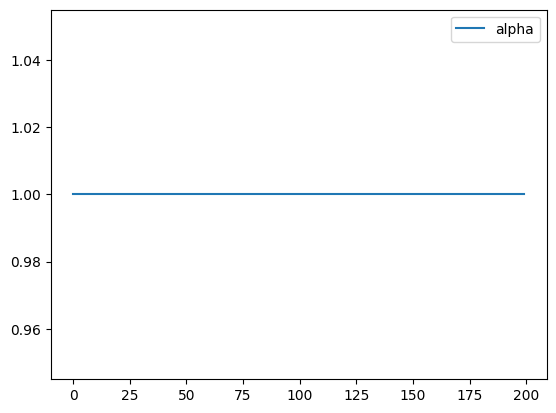

In [150]:
trace[[c for c in trace.columns if c.startswith('alpha')]].plot();

In [ ]:
#trace[['alpha']].plot();

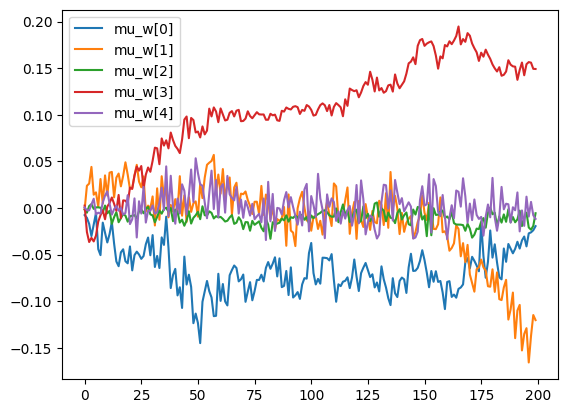

In [151]:
trace[[c for c in trace.columns if c.startswith('mu_w')]].plot();

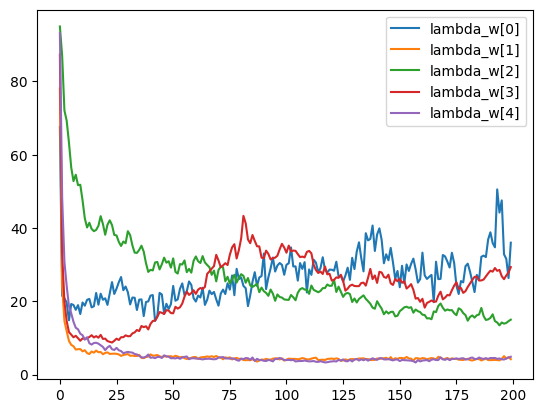

In [152]:
trace[[c for c in trace.columns if c.startswith('lambda_w')]].plot();

In [ ]:
#trace[[c for c in trace.columns if c.startswith('mu_V')]].plot();

In [ ]:
#trace[[c for c in trace.columns if c.startswith('lambda_V')]].plot();

Text(0.5, 1.0, 'rating boundary vs cutpoint')

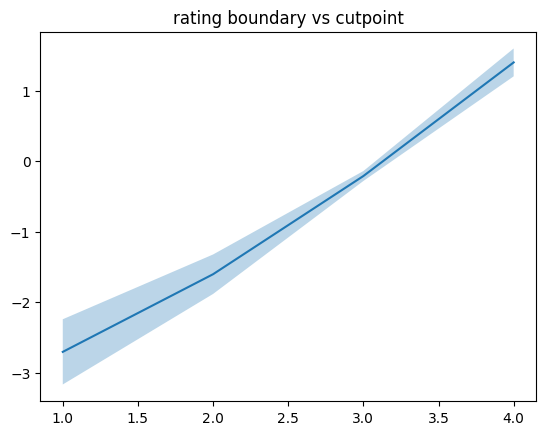

In [153]:
from matplotlib import pyplot as plt
cp_mean = cutpoints.mean(axis=0)
cp_std = cutpoints.std(axis=0)
plt.plot(np.arange(1, 5), cp_mean);
plt.fill_between(
np.arange(1, 5), cp_mean + 2*cp_std, cp_mean - 2 * cp_std,
alpha=0.3
)
plt.title('rating boundary vs cutpoint')